<a href="https://colab.research.google.com/gist/nextgencodes/030cf25c0a238853619df39905f1b563/welding_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welding Defect Classification

In this notebook, we build a deep learning model to classify images of welds as defective or not defective. We make use of a pre-trained model with transfer learning.

### Load Libraries

Load necessary libraries, and optionally install missing requirements.  If any other needed libraries are not installed, please install them with `!pip install <library name>`.

We also print out some data about the environment and set the seed.

In [ ]:
# !git clone https://github.com/nextgencodes/welding_defects.git
# !unzip welding_defects/Data.zip -d welding_defects

Cloning into 'welding_defects'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
Archive:  welding_defects/Data.zip
   creating: welding_defects/Data/binary_128x128_2000train/
   creating: welding_defects/Data/binary_128x128_2000train/test/
   creating: welding_defects/Data/binary_128x128_2000train/test/0/
 extracting: welding_defects/Data/binary_128x128_2000train/test/0/olabel_0_al5083_test_170905-112213-Al 2mm_frame_00163.png  
 extracting: welding_defects/Data/binary_128x128_2000train/test/0/olabel_0_al5083_test_170905-112213-Al 2mm_frame_00169.png  
 extracting: welding_defects/Data/binary_128x128_2000train/test/0/olabel_0_al5083_test_170905-112213-Al 2mm_frame_00172.png  
 extracting: welding_defects/Data/binary_128x128_2000train/test/0/olabel_0_al5083_test_170905-112213-Al 2mm_frame_00177.png  
 extract

In [2]:
# # Install the following libraries with pip, if not already available:
# !pip install matplotlib
# !pip install tf2onnx
# !pip install numba

import os

import numpy as np
from numpy.random import seed
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import applications, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, accuracy_score
from PIL import Image

import tf2onnx
import onnx

from time import perf_counter

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2969363118318296524
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2900570932
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13125771178507289692
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
# Print library versions
print('numpy:', np.__version__)
print('tensorflow:', tf.__version__)

# Print backend and image data format
print('backend:', K.backend())
print('image data format:', K.image_data_format())

# Set seed 
seed(1)
tf.compat.v1.set_random_seed(2)

numpy: 1.19.5
tensorflow: 2.6.2
backend: tensorflow
image data format: channels_last


### Define functions and set environment and model training variables

In [5]:
def plot_history(model_hist):
    '''Given model training data, plot the model training history.'''
    plt.plot(model_hist.history['accuracy'])
    plt.plot(model_hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return

def print_performance(y_truth, y_pred_class):
    '''Given ground truth and predicted labels, print the performance of the model:
        - Confusion Matrix
        - Accuracy
        - Matthews Correlation Coefficient
    '''
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_truth, y_pred_class))

    print("Accuracy: {0:.4f}".format(accuracy_score(y_truth, y_pred_class)))
    print("MCC:      {0:.4f}".format(matthews_corrcoef(y_truth, y_pred_class)))
    return


def list_files(path):
    '''List files recursively for a given path. Use full path for each file.'''
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(r, file))
    return files

def print_pil_img_info(an_img_path):
    '''Print info for image opened with PIL Image'''
    an_img = Image.open(an_img_path)
    print("format:", an_img.format)
    print("mode:", an_img.mode)
    print("size:", an_img.size)

The data used for model training is contained in the folder `binary_128x128_2000train`. This folder contains sub-folders `test`, `train`, and `val`.

In [6]:
# Print the data directory structure
print(os.listdir("Data"))
print(os.listdir("Data/binary_128x128_2000train"))

# Set folder variables
proj_dir = "."
dataset_base_dir = 'Data/binary_128x128_2000train/'
TRAIN_DIR = dataset_base_dir + 'train'
VAL_DIR = dataset_base_dir + 'val'
TEST_DIR = dataset_base_dir + 'test'

# Get number of samples in each folder
num_train_samples = len(list_files(os.path.join(proj_dir, TRAIN_DIR)))
num_val_samples = len(list_files(os.path.join(proj_dir, VAL_DIR)))
num_test_samples = len(list_files(os.path.join(proj_dir, TEST_DIR)))

['binary_128x128_2000train', 'testDefectImage.png', 'testNoDefectImage.png']
['test', 'train', 'val']


### Check data
The data is split into training, validation, and test sets. The train set is used to train the model, and validation set is used to check performance during training. The test set is held out until the end to check final model performance.

To get an idea of what the data looks like, we load a sample image from the training folder and print its metadata.

2000 600 600


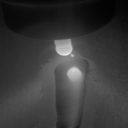

format: PNG
mode: L
size: (128, 128)


In [7]:
# Print the number of images in train, validation, and test directories
print(num_train_samples, num_val_samples, num_test_samples)

# Load an image and print image metadata
from PIL import Image
sample_img_path = list_files(os.path.join(proj_dir, TRAIN_DIR))[0]

sample_img = Image.open(sample_img_path)
display(sample_img)
print_pil_img_info(sample_img_path)

### Define data generators

Define the data generators used during training and testing. The training data generator includes a few transformations that are applied to images during training.

In [94]:
# Set model training variables
batch_size = 32
tile_size = (128,128) 

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.5)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=tile_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode = 'rgb',
        shuffle = False)

validation_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=tile_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode = 'rgb',
        shuffle = False)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = tile_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset='training',
    shuffle = False)

test_generator_val = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = tile_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset='validation',
    shuffle = False)

# plot_losses = PlotLosses()

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


### Define model

We start with a MobileNet model and modify it for our needs.

In [8]:
model_lst = [             applications.MobileNetV2]

# model_lst = [applications.Xception,
#              applications.InceptionResNetV2,
#              applications.MobileNet,
#              applications.InceptionV3,
#              applications.MobileNetV2]

##################################################### MobileNetV2 ###################################################
Epoch 1/15
62/62 [==============================] - 11s 126ms/step - loss: 0.4206 - accuracy: 0.8105 - val_loss: 0.2435 - val_accuracy: 0.8872
Epoch 2/15
62/62 [==============================] - 7s 111ms/step - loss: 0.2524 - accuracy: 0.8918 - val_loss: 0.2020 - val_accuracy: 0.9149
Epoch 3/15
62/62 [==============================] - 7s 112ms/step - loss: 0.2264 - accuracy: 0.9029 - val_loss: 0.2060 - val_accuracy: 0.9062
Epoch 4/15
62/62 [==============================] - 7s 111ms/step - loss: 0.2007 - accuracy: 0.9121 - val_loss: 0.2189 - val_accuracy: 0.9028
Epoch 5/15
62/62 [==============================] - 7s 113ms/step - loss: 0.1934 - accuracy: 0.9141 - val_loss: 0.2088 - val_accuracy: 0.9097
Epoch 6/15
62/62 [==============================] - 7s 112ms/step - loss: 0.1850 - accuracy: 0.9294 - val_loss: 0.2776 - val_accuracy: 0.8958
Epoch 7/15
62/62 [===========

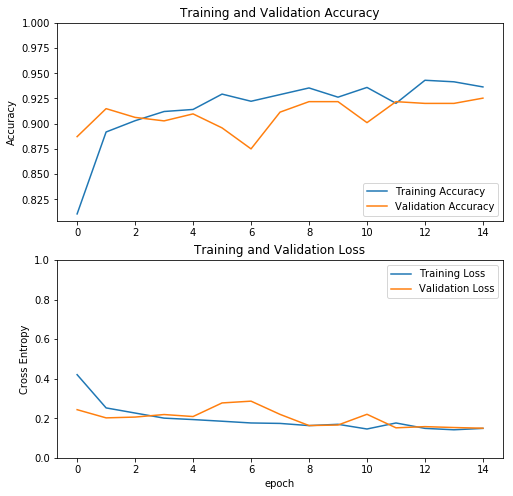

15/15 [==============================] - 1s 39ms/step - loss: 0.2748 - accuracy: 0.8562

Model performance on test dataset:
0.856249988079071
160
100
Epoch 15/30
62/62 [==============================] - 11s 131ms/step - loss: 1.2880 - accuracy: 0.8704 - val_loss: 0.2011 - val_accuracy: 0.9149
Epoch 16/30
62/62 [==============================] - 7s 114ms/step - loss: 0.1766 - accuracy: 0.9472 - val_loss: 0.1228 - val_accuracy: 0.9549
Epoch 17/30
62/62 [==============================] - 8s 119ms/step - loss: 0.1016 - accuracy: 0.9604 - val_loss: 0.1446 - val_accuracy: 0.9444
Epoch 18/30
62/62 [==============================] - 8s 117ms/step - loss: 0.0849 - accuracy: 0.9680 - val_loss: 0.1416 - val_accuracy: 0.9271
Epoch 19/30
62/62 [==============================] - 8s 118ms/step - loss: 0.0654 - accuracy: 0.9766 - val_loss: 0.1415 - val_accuracy: 0.9392
Epoch 20/30
62/62 [==============================] - 8s 117ms/step - loss: 0.0510 - accuracy: 0.9807 - val_loss: 0.1409 - val_accuracy

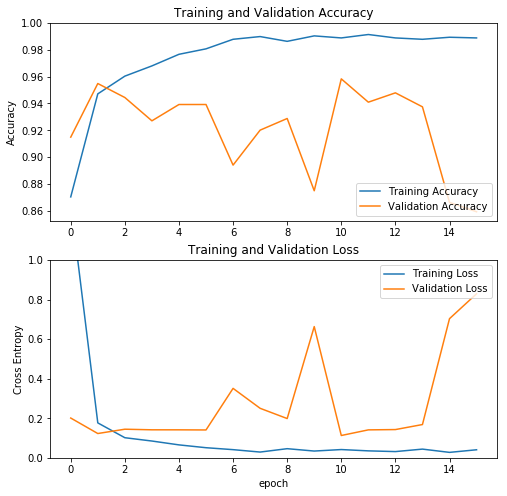

15/15 [==============================] - 1s 39ms/step - loss: 1.8846 - accuracy: 0.6729

Model performance on test dataset:
0.6729166507720947


In [9]:
from numba import cuda 
nets = len(model_lst)
model = [0]*nets
history_base = [0]*nets
history_fine = [0]*nets

for i,j in enumerate(model_lst):
    device = cuda.get_current_device()
    filename = str(j).split(" ")[1]

    print("##################################################### {} ###################################################".format(filename))
    # Define base model
    base_model = j(weights = "imagenet",
                                 include_top=False,
                                 input_shape = (tile_size[0], tile_size[1], 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(tile_size) + (3,))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(150, activation='relu')(x)
    x = layers.Flatten(name = "flatten")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation = 'softmax')(x)

    model[i] = models.Model(inputs, outputs)

    base_learning_rate = 0.001

    model[i].compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer = optimizers.Adam(learning_rate = base_learning_rate),
                metrics = ["accuracy"])

    # Uncomment the following line to see the (long) model summary
    # print(model.summary())
    initial_epochs = 15

    tic = perf_counter()
    history_base[i] = model[i].fit(
          train_generator,
          steps_per_epoch= num_train_samples // batch_size,
          epochs=initial_epochs,
          validation_data=validation_generator,
          validation_steps= num_val_samples // batch_size)
    toc = perf_counter()
    print(f"Trained model in {toc - tic:0.4f} seconds")


    acc = history_base[i].history['accuracy']
    val_acc = history_base[i].history['val_accuracy']

    loss = history_base[i].history['loss']
    val_loss = history_base[i].history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    _, acc = model[i].evaluate(test_generator, steps = None)
#     y_pred_class = np.array([np.argmax(x) for x in y_pred])
#     y_truth = test_generator.classes

    print("\nModel performance on test dataset:")
    print(acc)


    # Fine-tune from this layer onwards
    fine_tune_at = int(len(base_model.layers)*0.4)
    base_model.trainable = True
    print(len(model[i].trainable_variables))

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print(len(model[i].trainable_variables))

    model[i].compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

    fine_tune_epochs = 15
    total_epochs =  initial_epochs + fine_tune_epochs

    tic = perf_counter()
    history_fine[i] = model[i].fit(train_generator,
                          steps_per_epoch= num_train_samples // batch_size,
                          epochs=total_epochs,
                          initial_epoch=history_base[i].epoch[-1],
                          validation_data=validation_generator,
                          validation_steps= num_val_samples // batch_size)
    toc = perf_counter()
    print(f"Trained model in {toc - tic:0.4f} seconds")

    acc = history_fine[i].history['accuracy']
    val_acc = history_fine[i].history['val_accuracy']

    loss = history_fine[i].history['loss']
    val_loss = history_fine[i].history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    _, acc = model[i].evaluate(test_generator, steps = None)

    print("\nModel performance on test dataset:")
    print(acc)

    model[i].save('{}.h5'.format(filename))
    device.reset()

In [10]:
from tensorflow.keras.models import load_model
import tensorflow.keras
import tensorflow as tf

In [101]:
#Initiating the usage of individual models
keras_model = tensorflow.keras.models.load_model('MobileNetV2.h5', compile=False)
keras_model._name = 'mobilenetv2'
keras_model2 = tensorflow.keras.models.load_model('InceptionV3.h5', compile=False) 
keras_model2._name = 'inception'
keras_model3 = tensorflow.keras.models.load_model('MobileNet.h5', compile=False) 
keras_model3._name = 'mobilenet'
keras_model4 = tensorflow.keras.models.load_model('InceptionResNetV2.h5', compile=False) 
keras_model4._name = 'inceptionresnet'
keras_model5 = tensorflow.keras.models.load_model('Xception.h5', compile=False) 
keras_model5._name = 'xception'
models = [keras_model, keras_model2, keras_model3,keras_model4, keras_model5] #stacking individual models in a list
model_input = tf.keras.Input(shape=(128, 128, 3)) #takes a list of tensors as input, all of the same shape
model_outputs = [model(model_input) for model in models] #collects outputs of models in a list
ensemble_output = tf.keras.layers.Average()(model_outputs) #averaging outputs
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [102]:
pred = keras_model2.predict_generator(test_generator)
y_pred_class = np.array([np.argmax(x) for x in pred])
y_truth = test_generator.classes
accuracy_score(y_truth, y_pred_class)

0.9666666666666667

In [103]:
pred = keras_model3.predict_generator(test_generator)
y_pred_class = np.array([np.argmax(x) for x in pred])
y_truth = test_generator.classes
accuracy_score(y_truth, y_pred_class)

0.9733333333333334

In [104]:
pred = keras_model4.predict_generator(test_generator)
y_pred_class = np.array([np.argmax(x) for x in pred])
y_truth = test_generator.classes
accuracy_score(y_truth, y_pred_class)

0.9733333333333334

In [105]:
pred = keras_model5.predict_generator(test_generator)
y_pred_class = np.array([np.argmax(x) for x in pred])
y_truth = test_generator.classes
accuracy_score(y_truth, y_pred_class)

0.95

In [106]:
pred = ensemble_model.predict_generator(test_generator)
y_pred_class = np.array([np.argmax(x) for x in pred])
y_truth = test_generator.classes
accuracy_score(y_truth, y_pred_class)

0.9966666666666667